<a href="https://colab.research.google.com/github/Anjan-AI/TSAI-EVA5/blob/master/Session%2011%20-%20Super%20Convergence/EVA5_Session_11_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Added the modular files to the drive and added to path

In [1]:
%rm -rf TSAI-EVA5/

In [2]:

!git clone https://github.com/Anjan-AI/TSAI-EVA5.git

Cloning into 'TSAI-EVA5'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 706 (delta 40), reused 72 (delta 18), pack-reused 607
Receiving objects: 100% (706/706), 38.77 MiB | 16.92 MiB/s, done.
Resolving deltas: 100% (295/295), done.


In [3]:
import sys
sys.path.append('/content/TSAI-EVA5/Session 11 - Super Convergence/')
#sys.path.append('/content/TSAI-EVA5/Session 9 - DATA AUGMENTATION')

### Import all the Library

In [4]:
import torch
import os
import torchvision
import torchvision.transforms as transfroms
from Dataset.dataset import Dataset,cifar10_classes
#from Dataset.image_augmentations import AlbumentationTransforms
from Dataset.image_aug import AlbumentationTransforms
from Utils.SetCuda import set_seed,initialize_cuda
from Utils.utilities import print_model_summary,cross_entropy_loss
from Utils.evaluate import show_misclassified_images,evaluate_classwise_accuracy
from Utils.GradCam import GradCamView
from Utils.show_image import imshow ,show_train_data
#from models.resnet import ResNet18
from models.S11_model import NewResnet
from Training.Training_Testing import train ,test,runmodel

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from Utils.lr_finder import LRFinder

import albumentations as A

In [6]:
classes = cifar10_classes()
#define the transformation 


channel_means = (0.4914, 0.4822, 0.4465)
channel_stdevs = (0.2471, 0.2435, 0.2616)
train_transform = AlbumentationTransforms([
                                       #A.Rotate((-30.0, 30.0)),
                                       A.PadIfNeeded(min_height=36, min_width=36,always_apply=True),
                                       A.RandomCrop(height=32, width=32, always_apply=True,p=0.7),
                                       A.HorizontalFlip(p=0.7),
                                       A.VerticalFlip(p=0.7),
                                       #A.HueSaturationValue(p=0.3),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=0.8,always_apply=True)
                                       ])
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs)])

# allocate the transfroamtions to the the Data class
Data = Dataset(train_transform, test_transform)
# downlaod the data
train_set = Data.download_cifar10dataset(train = True)
test_set = Data.download_cifar10dataset(train = False)

#check for the GUP avaliblbity and manual seeding
seed =1
cuda,device = initialize_cuda(seed)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
GPU Available? True


In [7]:
# Load the test and train data , set the batch size & Num_workeres.
train_loader = Data.data_loader(train_set,cuda= cuda ,batch_size = 512 , num_workers = 8 )
test_loader = Data.data_loader(test_set,cuda= cuda ,batch_size = 512 , num_workers = 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

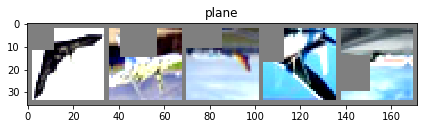

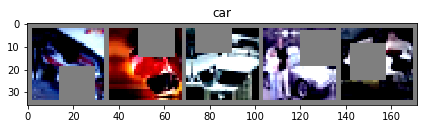

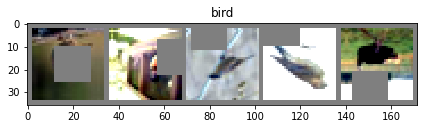

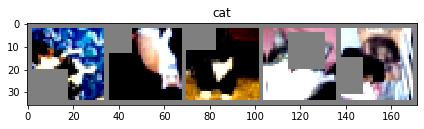

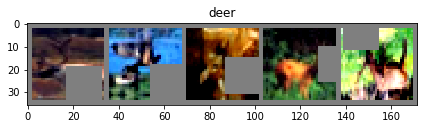

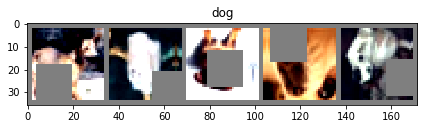

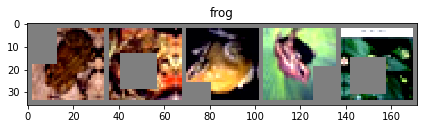

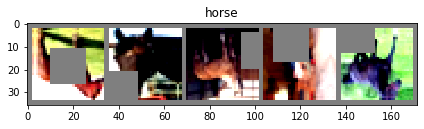

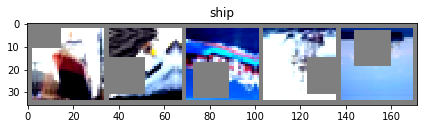

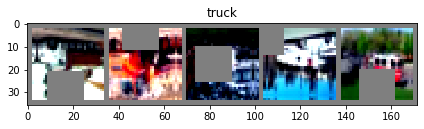

In [8]:
show_train_data(train_loader, classes)

In [16]:
# laod the model and print teh summary
model = NewResnet()
print_model_summary(model, input_size = (3,32,32),device =device)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

## Best Learning Rate Finder 


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.70E-02


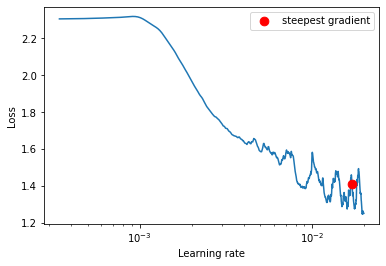

(<matplotlib.axes._subplots.AxesSubplot at 0x7f36f6ac0240>,
 0.016963121869782972)

In [10]:
criterion = cross_entropy_loss() 
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9,weight_decay = 0.00001)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=0.02, num_iter=600 ,step_mode="linear")
lr_finder.plot()

In [11]:
Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
Best_lr

0.019866510851419033

In [12]:
lr_finder.reset()

### one cyclic Scheduler

In [17]:
#Best_lr = 0.05478901179593945
from torch.optim.lr_scheduler import OneCycleLR
model = NewResnet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay = 0.01)
criterion = cross_entropy_loss()

EPOCHS =25
scheduler = OneCycleLR(optimizer, max_lr = Best_lr, epochs=EPOCHS,
                       steps_per_epoch=len(train_loader), pct_start=0.3,
                       div_factor=25, final_div_factor=1)
       

train_losses = []
test_losses = []
train_acc = []
test_acc = []
print(device)
model = model.to(device)
batch_scheduler = True
l1_factor =0
runmodel(model,device,train_loader,test_loader,optimizer,scheduler,EPOCHS,criterion, train_losses,train_acc,test_losses,test_acc,l1_factor,batch_scheduler)


  0%|          | 0/98 [00:00<?, ?it/s]

cuda
EPOCH: 0


Loss=1.4371775388717651 Batch_id=97 Accuracy=32.24: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 4197/10000 (41.97%)

EPOCH: 1


Loss=1.346431016921997 Batch_id=97 Accuracy=49.20: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 4596/10000 (45.96%)

EPOCH: 2


Loss=1.316835641860962 Batch_id=97 Accuracy=55.79: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0025, Accuracy: 5530/10000 (55.30%)

EPOCH: 3


Loss=1.204620599746704 Batch_id=97 Accuracy=61.46: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0026, Accuracy: 5691/10000 (56.91%)

EPOCH: 4


Loss=0.8548139929771423 Batch_id=97 Accuracy=64.69: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 5995/10000 (59.95%)

EPOCH: 5


Loss=0.8230235576629639 Batch_id=97 Accuracy=68.83: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 6254/10000 (62.54%)

EPOCH: 6


Loss=0.7655553221702576 Batch_id=97 Accuracy=71.85: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0020, Accuracy: 6513/10000 (65.13%)

EPOCH: 7


Loss=0.677745521068573 Batch_id=97 Accuracy=73.97: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0019, Accuracy: 6790/10000 (67.90%)

EPOCH: 8


Loss=0.6586244106292725 Batch_id=97 Accuracy=76.29: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7133/10000 (71.33%)

EPOCH: 9


Loss=0.6053897142410278 Batch_id=97 Accuracy=77.41: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7094/10000 (70.94%)

EPOCH: 10


Loss=0.6008458137512207 Batch_id=97 Accuracy=78.62: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7476/10000 (74.76%)

EPOCH: 11


Loss=0.6586858630180359 Batch_id=97 Accuracy=80.04: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7287/10000 (72.87%)

EPOCH: 12


Loss=0.5327575206756592 Batch_id=97 Accuracy=80.51: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7204/10000 (72.04%)

EPOCH: 13


Loss=0.5562880635261536 Batch_id=97 Accuracy=81.31: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0016, Accuracy: 7218/10000 (72.18%)

EPOCH: 14


Loss=0.5786443948745728 Batch_id=97 Accuracy=82.29: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0013, Accuracy: 7796/10000 (77.96%)

EPOCH: 15


Loss=0.4708731174468994 Batch_id=97 Accuracy=82.87: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0015, Accuracy: 7402/10000 (74.02%)

EPOCH: 16


Loss=0.525005042552948 Batch_id=97 Accuracy=84.14: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7926/10000 (79.26%)

EPOCH: 17


Loss=0.4989863932132721 Batch_id=97 Accuracy=84.75: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0014, Accuracy: 7659/10000 (76.59%)

EPOCH: 18


Loss=0.38142791390419006 Batch_id=97 Accuracy=85.51: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0012, Accuracy: 7887/10000 (78.87%)

EPOCH: 19


Loss=0.4036431610584259 Batch_id=97 Accuracy=86.11: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 8204/10000 (82.04%)

EPOCH: 20


Loss=0.27197471261024475 Batch_id=97 Accuracy=87.56: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8394/10000 (83.94%)

EPOCH: 21


Loss=0.37887611985206604 Batch_id=97 Accuracy=88.68: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8497/10000 (84.97%)

EPOCH: 22


Loss=0.32553789019584656 Batch_id=97 Accuracy=89.88: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0007, Accuracy: 8726/10000 (87.26%)

EPOCH: 23


Loss=0.2757177948951721 Batch_id=97 Accuracy=90.64: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0008, Accuracy: 8695/10000 (86.95%)

EPOCH: 24


Loss=0.30106493830680847 Batch_id=97 Accuracy=91.25: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]



Test set: Average loss: 0.0007, Accuracy: 8835/10000 (88.35%)



In [18]:
evaluate_classwise_accuracy(model, device, classes, test_loader)

Accuracy of plane : 90 %
Accuracy of   car : 94 %
Accuracy of  bird : 84 %
Accuracy of   cat : 71 %
Accuracy of  deer : 86 %
Accuracy of   dog : 81 %
Accuracy of  frog : 92 %
Accuracy of horse : 91 %
Accuracy of  ship : 95 %
Accuracy of truck : 94 %


## Gradcam view of missclassfied Images 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

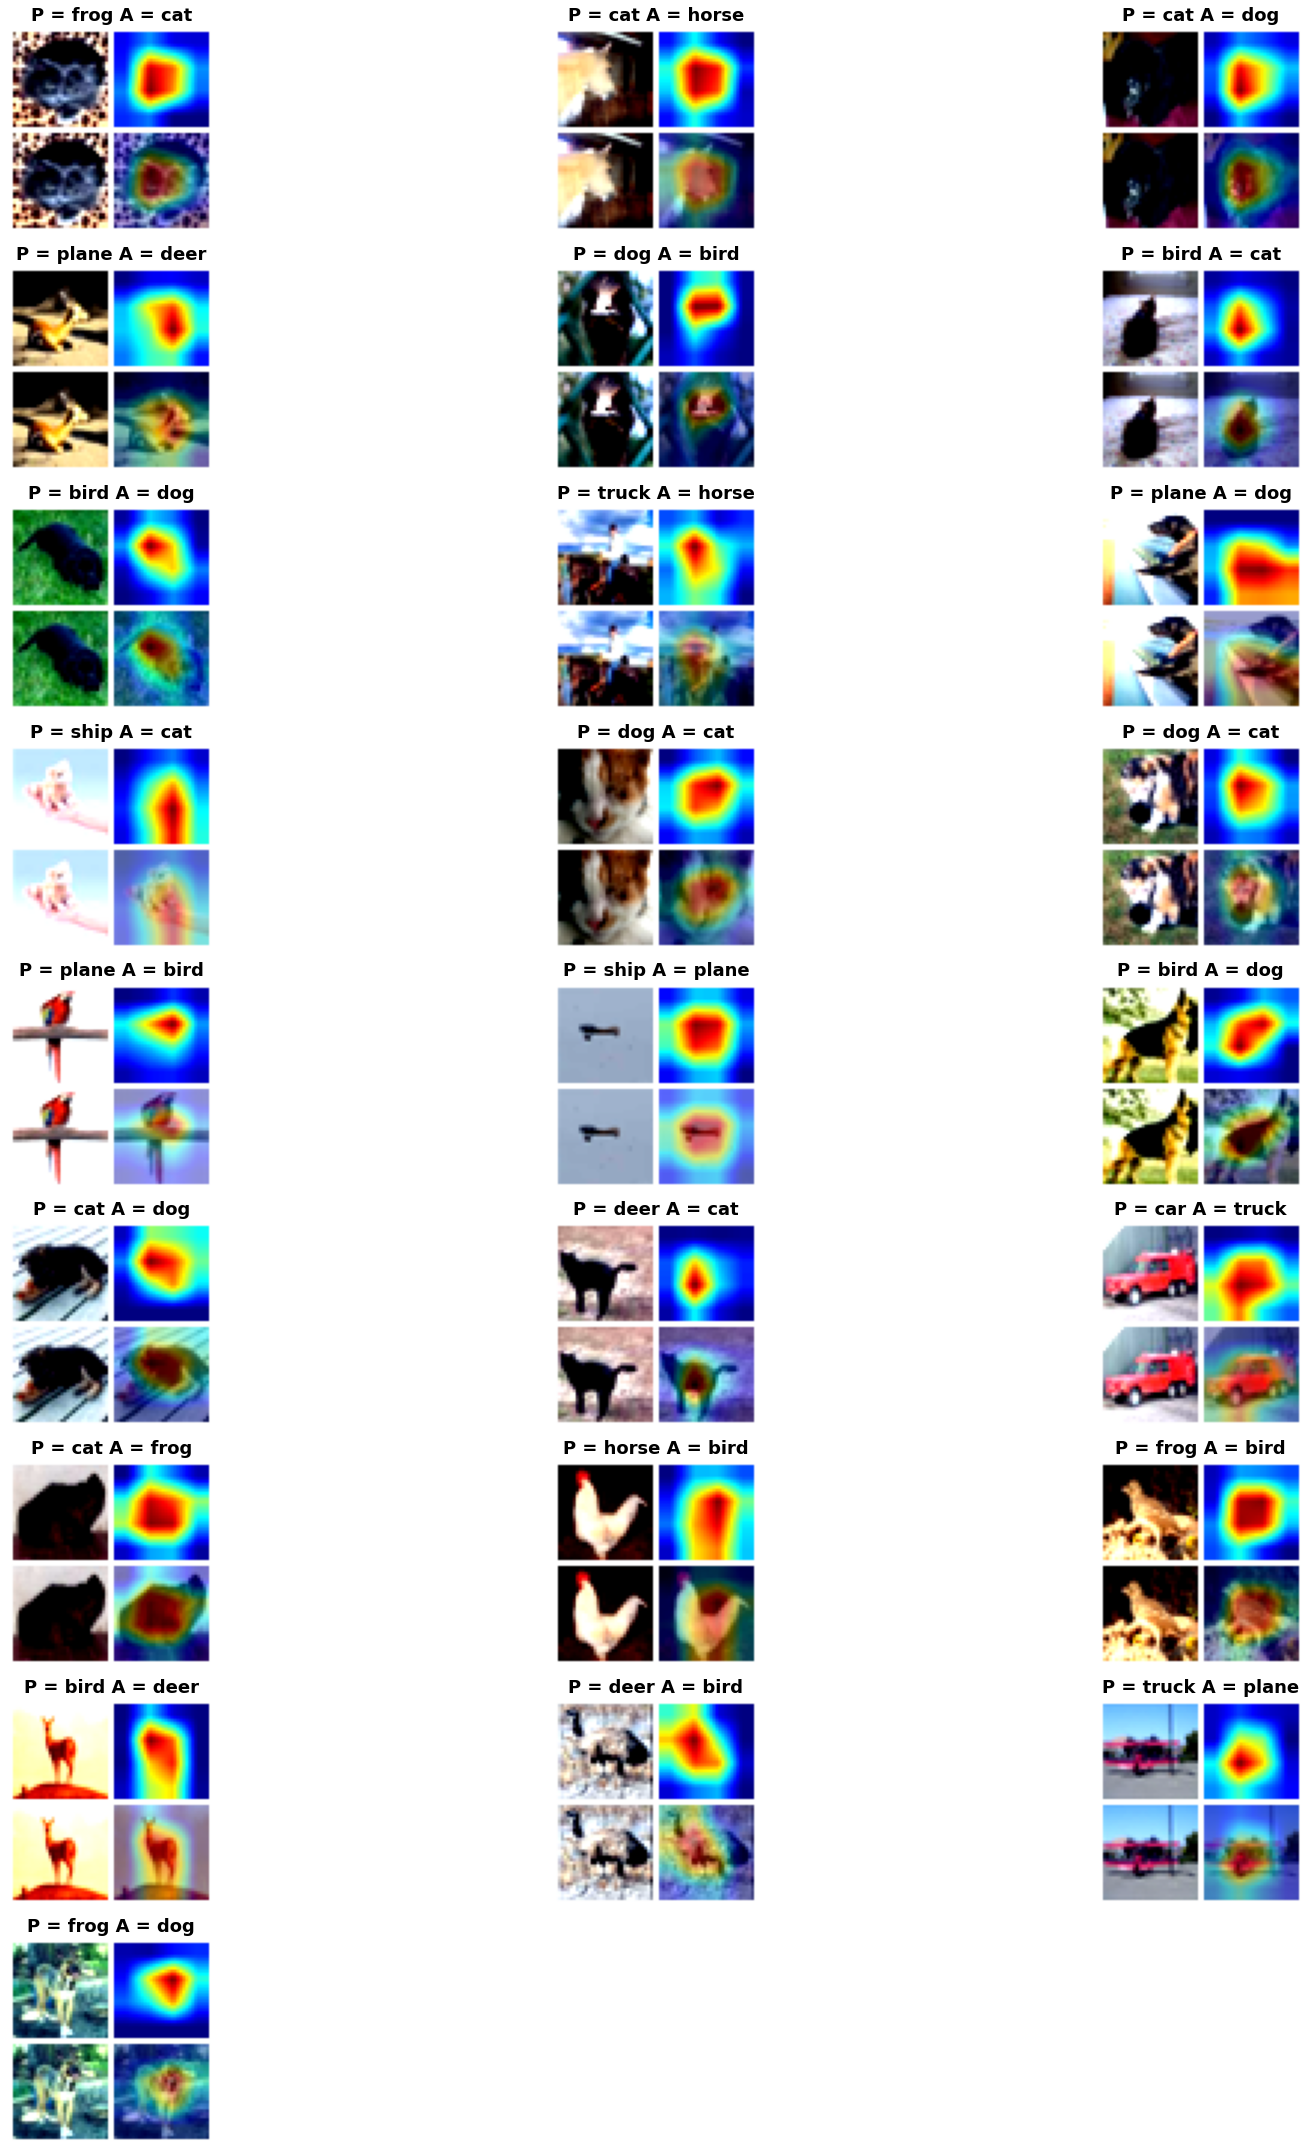

In [25]:
miscalssified_images = show_misclassified_images(model,device,test_loader,classes) # get he misclassfied Images
layers = [model.R2]  # layers that we want to see in Gradcam.
GradCamView(miscalssified_images,model,classes,layers) # call Gradcam class.

In [31]:
count =0
sum =0
train_batch_acc = []
for i in range(len(train_acc)):
  sum = sum +train_acc[i]
  count = count+1
  if(count == 98):
    train_batch_acc.append(sum/98)
    count =0
    sum =0


In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_metric1(train_acc, test_acc,metric):
    # Initialize a figure
    plt.style.use("dark_background")
    fig = plt.figure(figsize=(11, 9))
    
    # Plot values
    train_acc_plt, = plt.plot(train_acc)
    test_acc_plt, = plt.plot(test_acc)
    

    # Set plot title
    plt.title(f'{metric}')

    # Label axes
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    # Set legend
    location = 'upper' if ((metric == 'Test loss') or (metric == 'Train loss')) else 'lower'
    plt.legend(
        (train_acc_plt, test_acc_plt),
        ('Train Accuracy', 'Test Accuracy'),
        loc=f'{location} right',
        shadow=True,
        prop={'size': 10}
    )



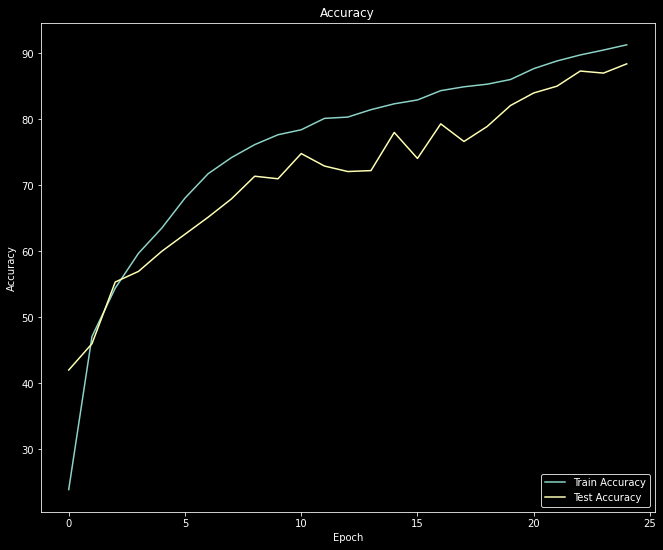

In [33]:
plot_metric1(train_batch_acc, test_acc,metric ='Accuracy')